# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [547]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [548]:
# Define a function to load data and aggregate them

def read_file(file_list) :
    df_combined = pd.DataFrame()
    for filenames in file_list :
        df_ = pd.read_csv(filenames)
        df_combined = pd.concat([df_combined,df_],ignore_index=True)
    
    return(df_combined)



In [549]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_list = ['AMZN_stocks_data.csv','GOOGL_stocks_data.csv','IBM_stocks_data.csv','MSFT_stocks_data.csv']

df = read_file(file_list)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [550]:
# View specifics of the data
print(df.shape)
print(df.isnull().sum())
df.info()


(12077, 7)
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [551]:
# Handle Missing Values
#Dropping rows with missing values
df.dropna(axis=0,inplace=True)
df.shape

(12076, 7)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

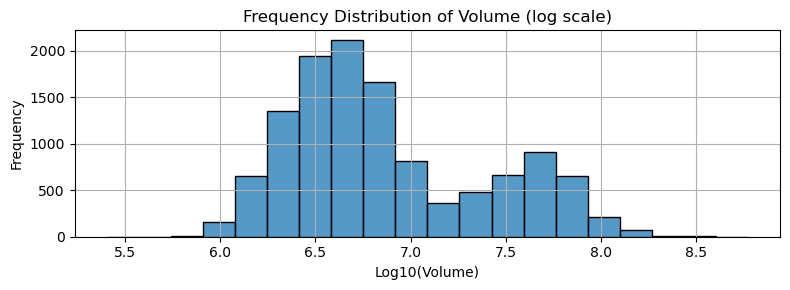

In [552]:
# Frequency distribution of volumes
df.head()
df['log_volume'] = np.log10(df['Volume'])

# Plot histogram of log(volume)
plt.figure(figsize=(8, 3))
sns.histplot(df['log_volume'], bins=20, kde=False)
plt.title('Frequency Distribution of Volume (log scale)')
plt.xlabel('Log10(Volume)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
df.drop(columns=['log_volume'],inplace=True)

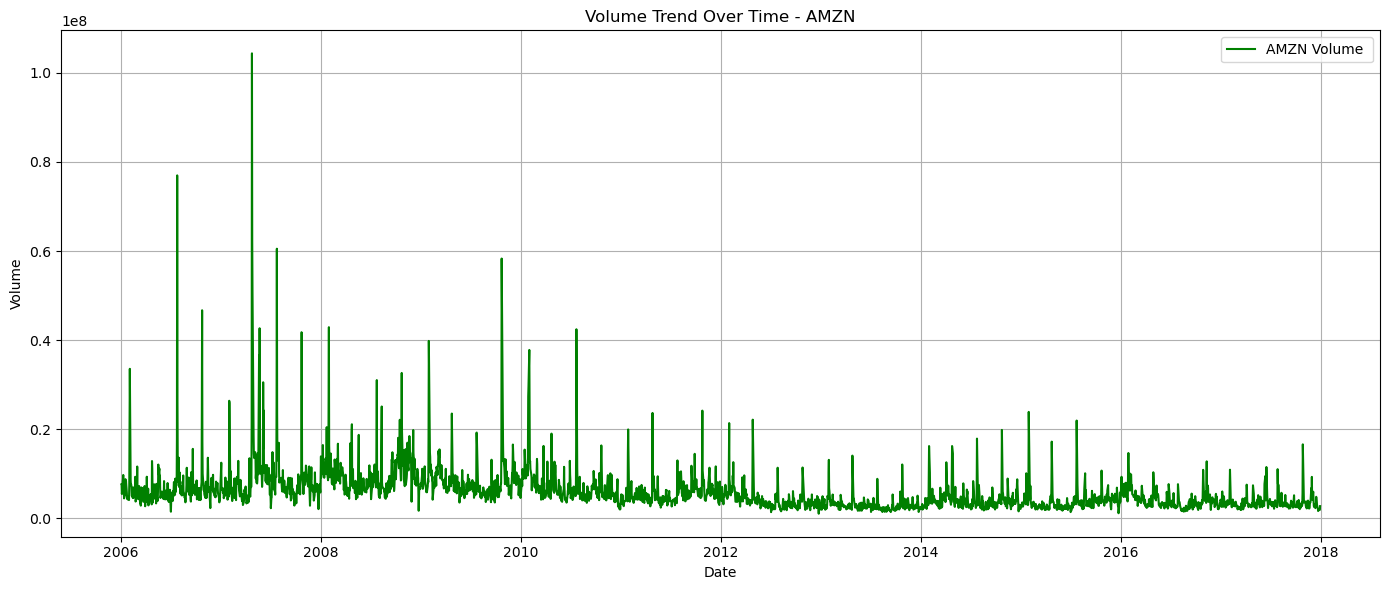

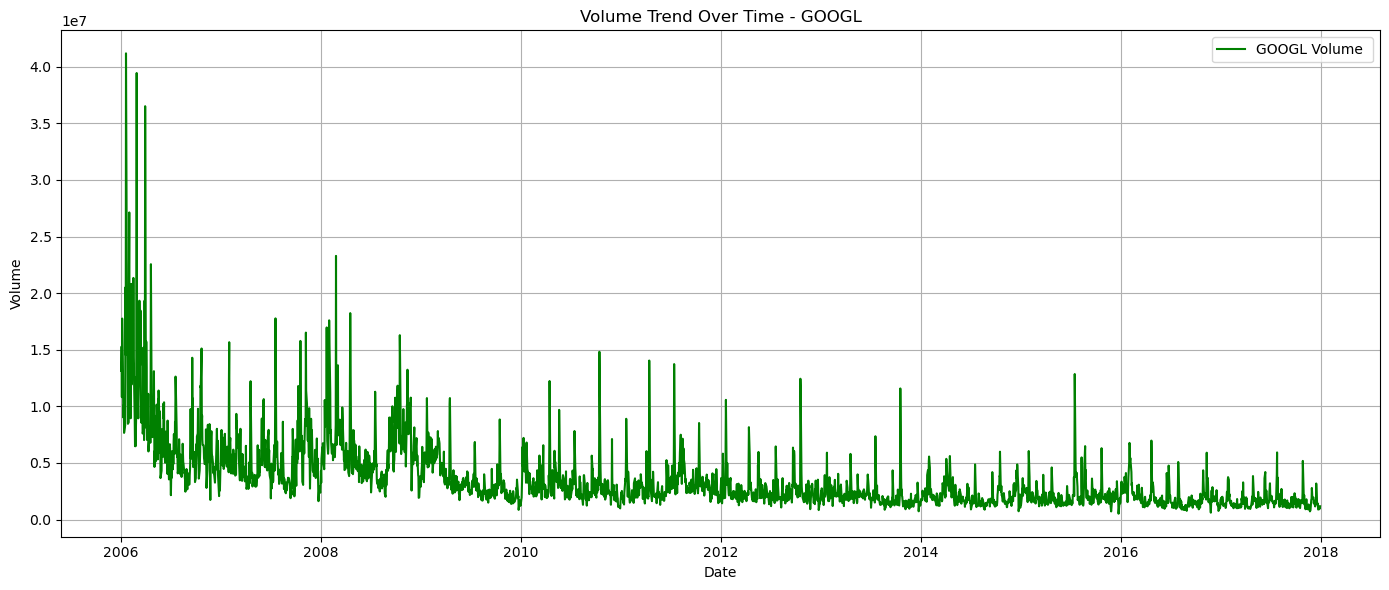

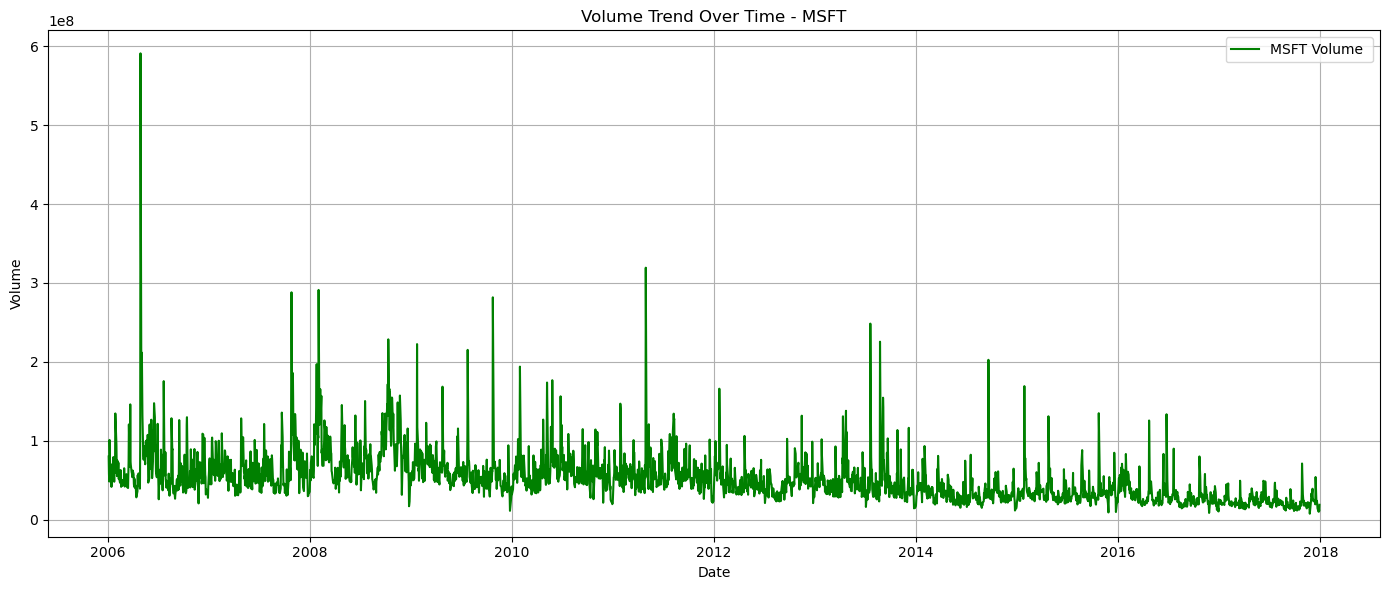

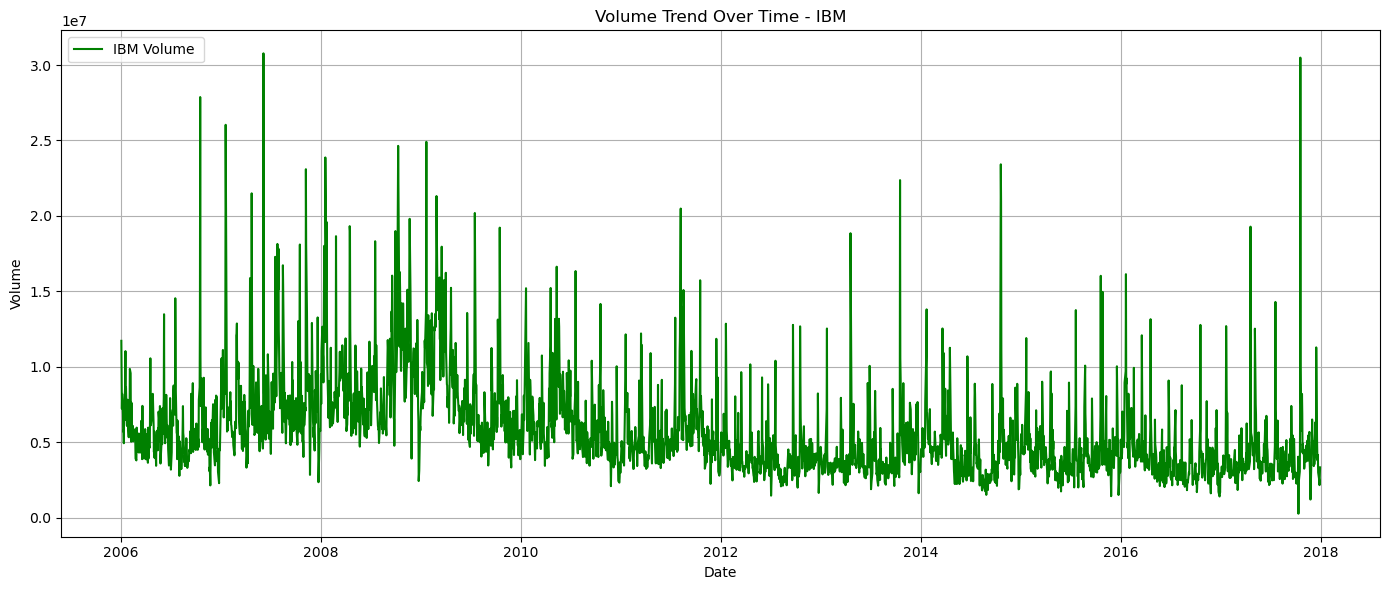

In [553]:
# Stock volume variation over time
df['Date'] = pd.to_datetime(df['Date'])
# Sort by date
df = df.sort_values(by='Date')
# Get list of unique stock names
stock_names = df['Name'].unique()

for stock in stock_names:
    stock_df = df[df['Name'] == stock].copy()

    plt.figure(figsize=(14, 6))
    plt.plot(stock_df['Date'], stock_df['Volume'], label=f'{stock} Volume ', color='green')
    plt.title(f"Volume Trend Over Time - {stock}")
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

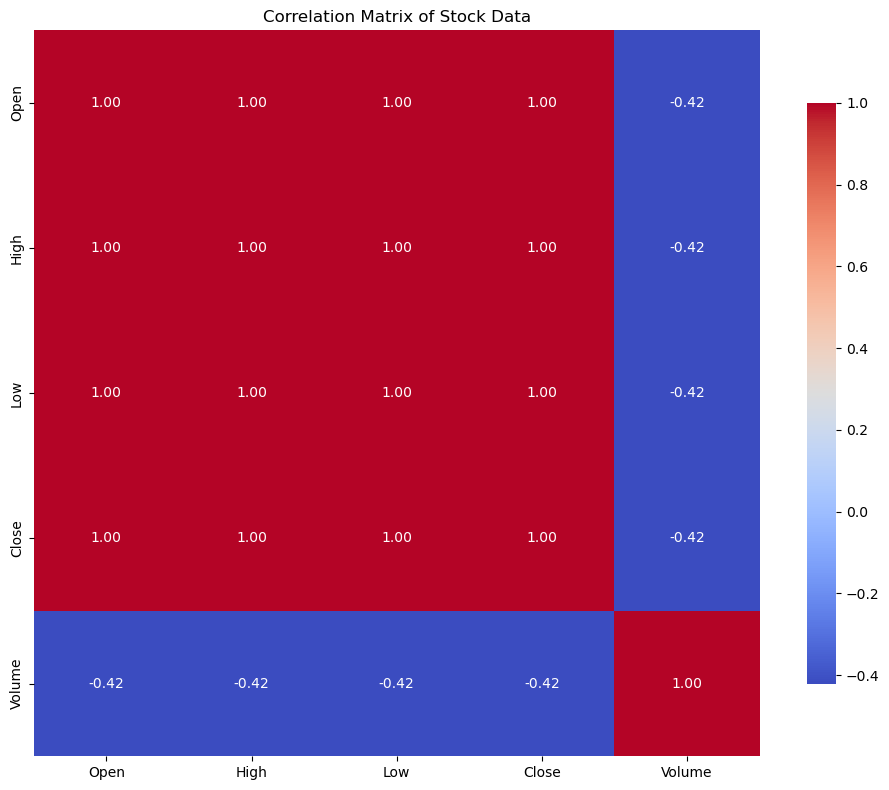

In [554]:
# Analyse correlations
# Calculate correlation matrix for numeric columns only
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Stock Data')
plt.tight_layout()
plt.show()



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [555]:
# Define a function that divides the data into windows and generates target variable values for each window

	


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [556]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scale_window(data,window_size):
    scaler = MinMaxScaler()
    scaled_data =scaler.fit(data)
    return scaled_data


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [557]:
# Define a function to create input and output data points from the master DataFrame
def create_sequences_rnn(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])    # Past windo_size days (all features)
        y.append(data[i + window_size, 3])      # Next day's 'close' (column index 3)
    return np.array(X), np.array(y)

# Create sequences per stock
window_size = 10
X_all, y_all = [], []

stock = 'GOOGL'

stock_df = df[df['Name'] == stock]
features = stock_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Normalize
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

X, y = create_sequences_rnn(features_scaled, window_size)
X_all.append(X)
y_all.append(y)

X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# Check shapes
print(X_train.shape)  
print(y_train.shape)  

print(X_test.shape)  
print(y_test.shape) 

(2407, 10, 5)
(2407,)
(602, 10, 5)
(602,)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [558]:
# Checking for patterns in different sequence lengths



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [559]:
# Create data instances from the master data frame using decided window size and window stride



In [560]:
# Check the number of data points generated


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [561]:
# Check if the datasets are compatible inputs to neural networks



## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [562]:
# Create a function that creates a simple RNN model according to the model configuration arguments


# Define RNN model
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(window_size, 5)),  # 5 = number of features
    Dense(1)  # Predict 1 value: next day's closing price
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0177 - val_loss: 0.0079
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9898e-04 - val_loss: 0.0050
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9568e-04 - val_loss: 0.0049
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3330e-05 - val_loss: 0.0038
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2980e-05 - val_loss: 0.0046
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8802e-05 - val_loss: 0.0042
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0944e-05 - val_loss: 0.0040
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3890e-05 - val_loss: 0.0032
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0256e-05 - val_loss: 0.0036
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8172e-05 - val_loss: 0.0027
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8028e-05 - val_loss: 0.0020
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [563]:
# Find an optimal configuration of simple RNN



In [564]:
# Find the best configuration based on evaluation metrics



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [565]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model



Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


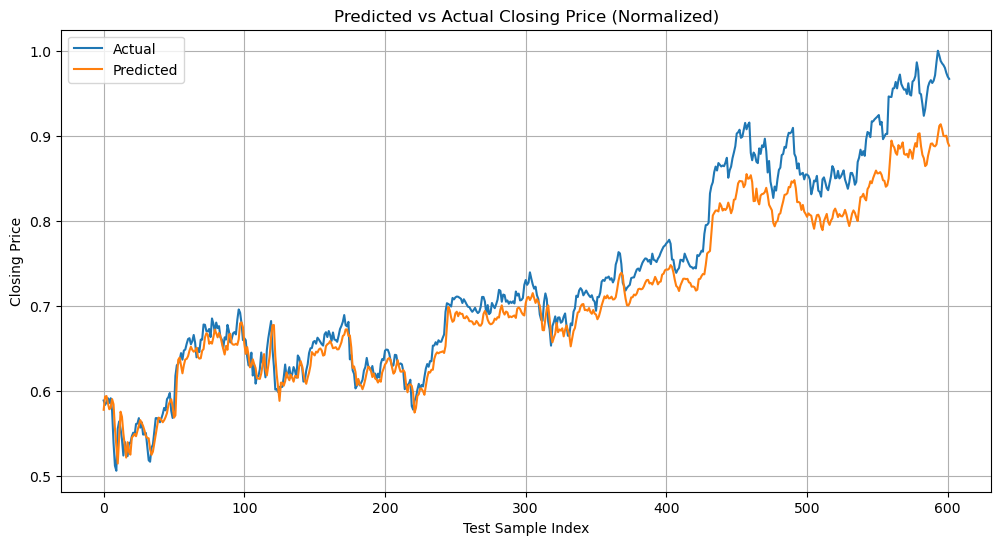

In [566]:
# Predict on the test data and plot

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs Actual Closing Price (Normalized)')
plt.xlabel('Test Sample Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()





It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [567]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Predict on test set
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²    = {r2:.4f}")



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE  = 0.03
RMSE = 0.04
R²    = 0.9102


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [568]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [569]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [570]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [571]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [572]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [573]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [574]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [575]:
# Find an optimal configuration of simple RNN



In [576]:
# Find the best configuration



In [577]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [578]:
# Compute the performance of the model on the testing data set



In [579]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [580]:
# Find an optimal configuration of advanced RNN



In [581]:
# Find the best configuration



In [582]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [583]:
# Compute the performance of the model on the testing data set



In [584]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.